In [1]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math
import numpy as np

In [2]:
df = quandl.get("WGC/GOLD_DAILY_USD")

In [3]:
df.shape

(10462, 1)

In [4]:
df['day'] = df.index.to_series()

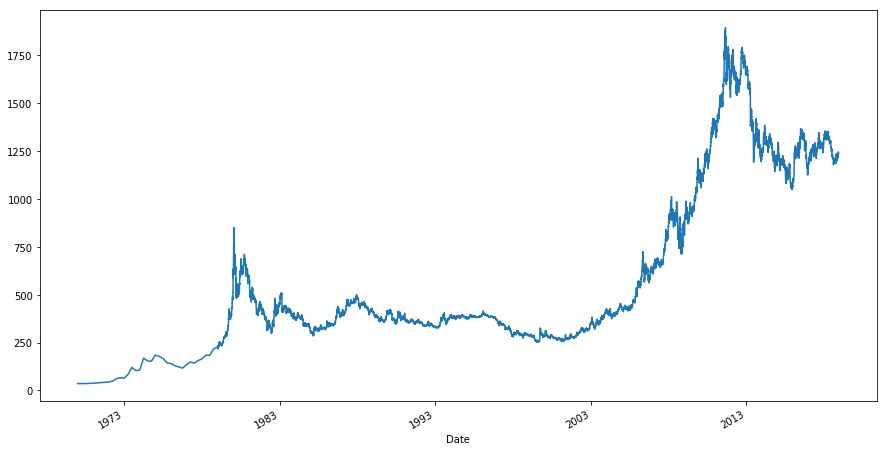

In [5]:
plt.rcParams['figure.figsize'] = [15, 8]
df.Value.plot.line();

In [6]:
df.head()

,Value,day
Date,,
1970-01-01,35.2,1970-01-01
1970-04-01,35.1,1970-04-01
1970-07-01,35.4,1970-07-01
1970-10-01,36.2,1970-10-01
1971-01-01,37.4,1971-01-01


#### Feature engineering

In [7]:
## Date features
df_features = df.copy()
df_features['dayofmonth'] = df_features.day.dt.day
df_features['dayofweek'] = df_features.day.dt.dayofweek
df_features['month'] = df_features.day.dt.month
df_features['year'] = df_features.day.dt.year
df_features.head()

,Value,day,dayofmonth,dayofweek,month,year
Date,,,,,,
1970-01-01,35.2,1970-01-01,1,3,1,1970
1970-04-01,35.1,1970-04-01,1,2,4,1970
1970-07-01,35.4,1970-07-01,1,2,7,1970
1970-10-01,36.2,1970-10-01,1,3,10,1970
1971-01-01,37.4,1971-01-01,1,4,1,1971


In [8]:
#### Value features
for i in range(1,4):
    df_features['value_d-'+str(i)] = df_features['Value'].shift(i)

# retira os primeiros registros após o shift, pois esses possuem NaN em suas colunas
df_features.dropna(inplace=True)

In [9]:
df_features.head()

,Value,day,dayofmonth,dayofweek,month,year,value_d-1,value_d-2,value_d-3
Date,,,,,,,,,
1970-10-01,36.2,1970-10-01,1,3,10,1970,35.4,35.1,35.2
1971-01-01,37.4,1971-01-01,1,4,1,1971,36.2,35.4,35.1
1971-04-01,38.9,1971-04-01,1,3,4,1971,37.4,36.2,35.4
1971-07-01,40.1,1971-07-01,1,3,7,1971,38.9,37.4,36.2
1971-10-01,42.0,1971-10-01,1,4,10,1971,40.1,38.9,37.4


In [10]:
# split into train and test sets
train_size = int(len(df_features) * 0.80)
test_size = len(df_features) - train_size
train = df_features[:train_size]
test = df_features[train_size:]

In [11]:
len(train), len(test), len(train) + len(test)

(8367, 2092, 10459)

#### random forest

In [12]:
reg = RandomForestRegressor(max_depth=5, random_state=42,n_estimators=100)

In [13]:
feats = df_features.columns
feats = feats[2:]
feats

Index(['dayofmonth', 'dayofweek', 'month', 'year', 'value_d-1', 'value_d-2',
       'value_d-3'],
      dtype='object')

In [14]:
reg.fit(train[feats], train['Value'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [15]:
trainPredict = reg.predict(train[feats])
testPredict = reg.predict(test[feats])

In [16]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(test['Value'], testPredict))

# RMSE
print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(test['Value'], testPredict)))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(test['Value'], testPredict))

Mean squared error: 20508.24
Root Mean squared error: 143.21
R2 score: 0.42


In [17]:
for i in range(9):
    trainPredict = np.insert(trainPredict, 0, [np.NaN])
for i in range(len(trainPredict)):
    testPredict = np.insert(testPredict, 0, [np.NaN])

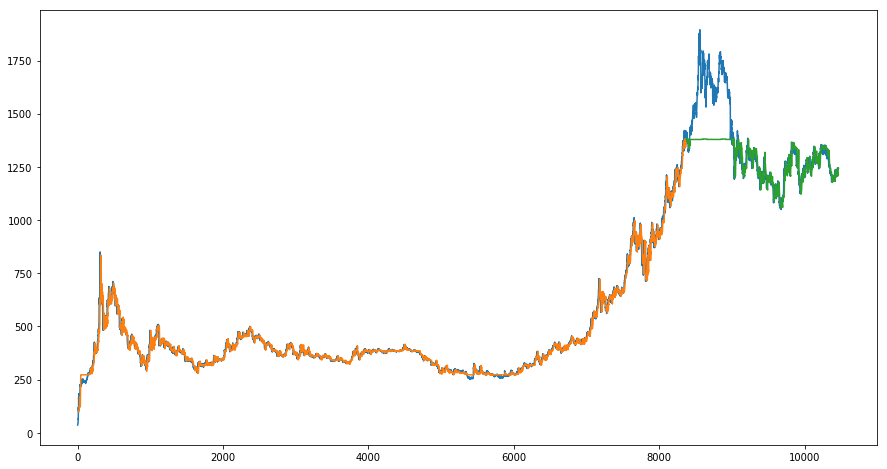

In [18]:
 # plot baseline and predictions
plt.plot(df_features['Value'].values)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.rcParams['figure.figsize'] = [15, 8]
plt.show()

In [19]:
estimator = reg.estimators_[9]

In [20]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = feats,
                class_names = df_features['Value'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [21]:
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [22]:
# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'data/tree.png')

Feature ranking:
1. feature value_d-1 (0.988961)
2. feature value_d-2 (0.007905)
3. feature value_d-3 (0.002676)
4. feature year (0.000446)
5. feature month (0.000012)
6. feature dayofmonth (0.000000)
7. feature dayofweek (0.000000)


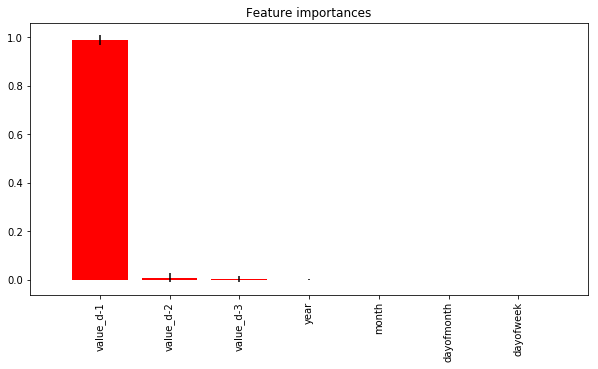

In [23]:
plt.rcParams['figure.figsize'] = [10, 5]
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train[feats].shape[1]):
    print("%d. feature %s (%f)" % (f + 1, train[feats].columns[indices[f]], importances[indices[f]]))

    
path_to_images = 'img/'
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train[feats].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train[feats].shape[1]), train[feats].columns[indices],rotation=90)
plt.xlim([-1, train[feats].shape[1]])
plt.savefig(path_to_images + 'importancia_features_regressor.png', bbox_inches='tight')
plt.show()